# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as ss

# Settings

In [2]:
# Widen the Jupyter Notebook as much as possible
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import Data

#### Source: https://www.kaggle.com/ydalat/lifestyle-and-wellbeing-data

In [3]:
# Import data
df = pd.read_csv('Wellbeing and Lifestyle\Wellbeing_and_lifestyle_data_Kaggle.csv', index_col=None, header=0 )
df.head()

,Timestamp,FRUITS_VEGGIES,DAILY_STRESS,PLACES_VISITED,CORE_CIRCLE,SUPPORTING_OTHERS,SOCIAL_NETWORK,ACHIEVEMENT,DONATION,BMI_RANGE,...,SLEEP_HOURS,LOST_VACATION,DAILY_SHOUTING,SUFFICIENT_INCOME,PERSONAL_AWARDS,TIME_FOR_PASSION,WEEKLY_MEDITATION,AGE,GENDER,WORK_LIFE_BALANCE_SCORE
0,7/7/15,3,2,2,5,0,5,2,0,1,...,7,5,5,1,4,0,5,36 to 50,Female,609.5
1,7/7/15,2,3,4,3,8,10,5,2,2,...,8,2,2,2,3,2,6,36 to 50,Female,655.6
2,7/7/15,2,3,3,4,4,10,3,2,2,...,8,10,2,2,4,8,3,36 to 50,Female,631.6
3,7/7/15,3,3,10,3,10,7,2,5,2,...,5,7,5,1,5,2,0,51 or more,Female,622.7
4,7/7/15,5,1,3,3,10,4,2,4,2,...,7,0,0,2,8,1,5,51 or more,Female,663.9


In [4]:
# View data
df.info()

# Observation:
# 1. No missing values
# 2. DAILY_STRESS column has inaccurate data type, it should be int64
# 3. To remove column 'Timestamp' as it is not material to the analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15972 entries, 0 to 15971
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Timestamp                15972 non-null  object 
 1   FRUITS_VEGGIES           15972 non-null  int64  
 2   DAILY_STRESS             15972 non-null  object 
 3   PLACES_VISITED           15972 non-null  int64  
 4   CORE_CIRCLE              15972 non-null  int64  
 5   SUPPORTING_OTHERS        15972 non-null  int64  
 6   SOCIAL_NETWORK           15972 non-null  int64  
 7   ACHIEVEMENT              15972 non-null  int64  
 8   DONATION                 15972 non-null  int64  
 9   BMI_RANGE                15972 non-null  int64  
 10  TODO_COMPLETED           15972 non-null  int64  
 11  FLOW                     15972 non-null  int64  
 12  DAILY_STEPS              15972 non-null  int64  
 13  LIVE_VISION              15972 non-null  int64  
 14  SLEEP_HOURS           

# Data Cleansing

In [5]:
# Check for duplicates across all columns
len(df[df.duplicated()])

# Duplicates here might be due to multiple submission by the same respondent

482

In [6]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# Check for duplicates across all columns again
len(df[df.duplicated()])

0

In [7]:
# Remove unuseful column
df.drop(columns='Timestamp', axis=1, inplace=True)

In [8]:
# View values under column DAILY_STRESS
df['DAILY_STRESS'].value_counts()

# Observation:
# - 1/1/00 is an inaccurate value

3         4230
2         3302
4         2903
1         2409
5         1987
0          658
1/1/00       1
Name: DAILY_STRESS, dtype: int64

In [9]:
# Check for work life balance score for DAILY_STRESS == 1/1/00
df[['DAILY_STRESS', 'WORK_LIFE_BALANCE_SCORE']][df['DAILY_STRESS'] == '1/1/00']

# Info:
# - Work life balance scoring used for the survey:
#  - Poor: Below 550
#  - Good: 550 - 700
#  - Excellent: Above 700

# Action:
# - Since this response's score is 682.6 which categorised as 'Good', the average value of DAILY_STRESS based on other response with 'Good' score will be assigned

,DAILY_STRESS,WORK_LIFE_BALANCE_SCORE
10005,1/1/00,682.6


In [10]:
# Set dtype
df['DAILY_STRESS'] = pd.to_numeric(df['DAILY_STRESS'], errors='coerce')

# Assign average value of DAILY_STRESS based on other response with 'Good' score
val = round(df['DAILY_STRESS'][(df['WORK_LIFE_BALANCE_SCORE'] >= 550) & (df['WORK_LIFE_BALANCE_SCORE'] < 700)].mean())
df.loc[df['DAILY_STRESS'].isnull(),'DAILY_STRESS'] = val

In [11]:
df['DAILY_STRESS'].value_counts().sort_index()

0.0     658
1.0    2409
2.0    3302
3.0    4231
4.0    2903
5.0    1987
Name: DAILY_STRESS, dtype: int64

In [12]:
# View numerical distribution
df.describe()

# Obseration:
# - Survey questions use different range of scores as follows:
#  * 1 or 2
#  * 1 to 5
#  * 1 to 10

,FRUITS_VEGGIES,DAILY_STRESS,PLACES_VISITED,CORE_CIRCLE,SUPPORTING_OTHERS,SOCIAL_NETWORK,ACHIEVEMENT,DONATION,BMI_RANGE,TODO_COMPLETED,...,DAILY_STEPS,LIVE_VISION,SLEEP_HOURS,LOST_VACATION,DAILY_SHOUTING,SUFFICIENT_INCOME,PERSONAL_AWARDS,TIME_FOR_PASSION,WEEKLY_MEDITATION,WORK_LIFE_BALANCE_SCORE
count,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,...,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000
mean,2.922466,2.792318,5.225823,5.513170,5.619496,6.489606,4.000194,2.716333,1.409038,5.749645,...,5.715946,3.752163,7.038476,2.891995,2.923951,1.730536,5.710394,3.321304,6.222660,666.841233
std,1.443356,1.369330,3.315740,2.839156,3.244341,3.084922,2.760281,1.851438,0.491672,2.623108,...,2.887100,3.225963,1.198948,3.686959,2.676001,0.443696,3.091236,2.728343,3.017574,45.001295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,480.000000
25%,2.000000,2.000000,2.000000,3.000000,3.000000,4.000000,2.000000,1.000000,1.000000,4.000000,...,3.000000,1.000000,6.000000,0.000000,1.000000,1.000000,3.000000,1.000000,4.000000,636.000000
50%,3.000000,3.000000,5.000000,5.000000,5.000000,6.000000,3.000000,3.000000,1.000000,6.000000,...,6.000000,3.000000,7.000000,0.000000,2.000000,2.000000,5.000000,3.000000,6.000000,667.900000
75%,4.000000,4.000000,8.000000,8.000000,10.000000,10.000000,6.000000,5.000000,2.000000,8.000000,...,8.000000,5.000000,8.000000,5.000000,4.000000,2.000000,9.000000,5.000000,10.000000,698.500000
max,5.000000,5.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,2.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,10.000000,10.000000,10.000000,820.200000


# Data Exploration

## Stress Level by Age Group

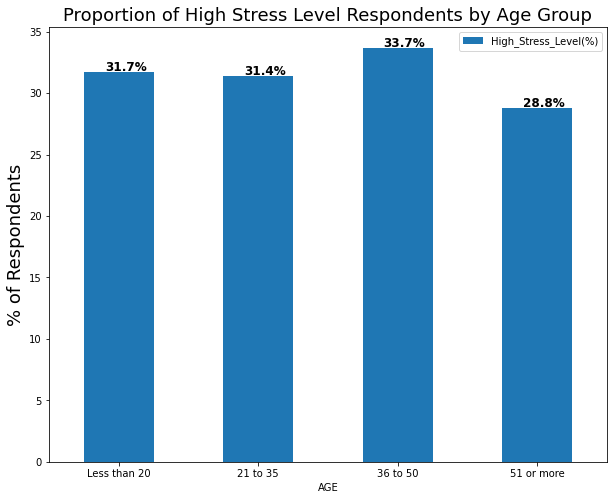

In [13]:
# Explore stress level by age group
def stress_level_by_age_group(df, col_stress, col_age, col_gender):
    
    '''
    INPUT:
    df - main dataframe
    col_stress - column that contains respondent's daily stress level
    col_age - column that contains respondent's age

    OUTPUT:
    Vertical bar chart of % of Respondents vs Age Group
    '''
    # Custom sort column age
    df[col_age] = pd.Categorical(df[col_age], ordered=True, categories=['Less than 20','21 to 35','36 to 50','51 or more'])

    # Generate pivot table that count number of respondents based on their daily stress Level & age Group
    table = pd.pivot_table(df, index=[col_age], columns=[col_stress], values=[col_gender], aggfunc='count')
    table.columns = table.columns.droplevel(0)
    table.reset_index(inplace=True)
    
    # Add additional column to count sum of each rows 
    table['Total_Rows'] = table.sum(axis=1)
    
    # Calculate and keep number of respondents with high level of stress ( Daily stress level with score or 4 or 5 only)
    table['High_Stress_Level'] = table[[4.0,5.0]].sum(axis=1)
    table.drop(columns=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0], axis=1, inplace=True)
    
    # Compute % of respondents with high stress level
    table['High_Stress_Level(%)'] = round(table['High_Stress_Level']/table['Total_Rows']*100, 1)
    
    # Plot bar graph
    ax = table.plot(x=col_age, y='High_Stress_Level(%)', kind='bar', colormap='tab10', figsize=(10, 8))
    ax.set_alpha(0.8)
    ax.set_title("Proportion of High Stress Level Respondents by Age Group", fontsize=18)
    ax.set_ylabel("% of Respondents", fontsize=18);
    plt.xticks(rotation=0)
    
    # set individual bar lables using above list
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()+0.15, i.get_height()+0.1,
                str(i.get_height())+'%', fontsize=12,
                    color='black', fontweight="bold")
          
    plt.show()



stress_level_by_age_group(df, 'DAILY_STRESS', 'AGE', 'GENDER')

# Observation:
# - Respondents aged 36 to 50 has the highest average daily stress level followed by age 21 to 35.

## Lifestyle of Respondents with High Daily Stress Level

In [14]:
# Proportion of respondents aged 36 to 50 with daily stress level more than 4
round(len(df[(df['AGE'] == '36 to 50') & (df['DAILY_STRESS'] >= 4)])/len(df)*100,1)

# Observation
# - There are 10% of respondents with high daily stress level aged 36 to 50

9.9

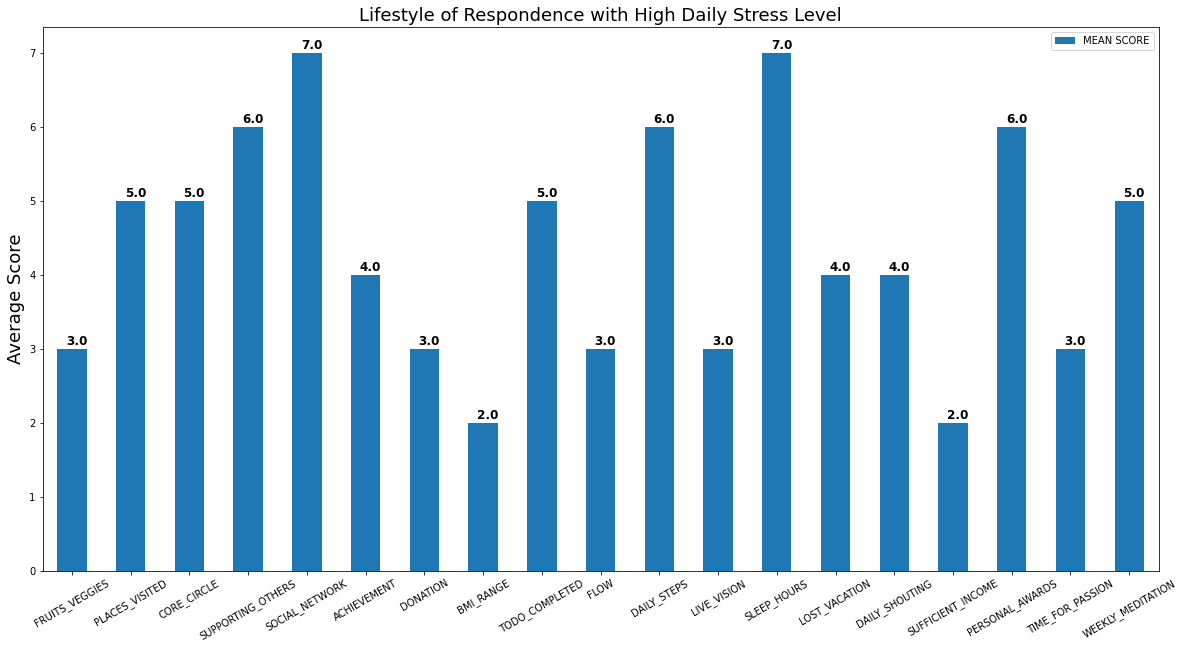

In [15]:
# Explore mean values of each column to understand lifestyle attributes of 36 to 50 age group with high daily stress level

def lifestyle_high_stress_lvl(df, col_stress, col_age):
    '''
    INPUT:
    df - main dataframe
    col_stress - column that contains respondent's daily stress level
    col_age - column that contains respondent's age

    OUTPUT:
    Vertical bar chart that visualise the mean score of each lifestyle attributes.
    '''
    
    # Create table of mean values of each column
    table = pd.DataFrame(round(df[(df['AGE'] == '36 to 50')&(df['DAILY_STRESS'] >= 4)].mean(),0))
    table.columns=['MEAN SCORE']
    
    # Remove unwanted indices which are DAILY_STRESS_LEVEL and WORK_LIFE_BALANCE_SCORE as clearly DAILY_STRESS_LEVEL will be >= 4. WORK_LIFE_BALANCE_SCORE is the score generated based on respondent's answers to the survey questions.
    table.drop(table.index[[1,20]],inplace=True)
    
    # Plot bar graph
    ax = table.plot(kind='bar', colormap='tab10', figsize=(20, 10))
    ax.set_alpha(0.8)
    ax.set_title("Lifestyle of Respondence with High Daily Stress Level", fontsize=18)
    ax.set_ylabel("Average Score", fontsize=18);
    plt.xticks(rotation=30)
    
    # Set individual bar lables using above list
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()+0.15, i.get_height()+0.05, 
                str(i.get_height()), fontsize=12, 
                color='black', fontweight="bold")
          
    plt.show()



lifestyle_high_stress_lvl(df, 'DAILY_STRESS', 'AGE')

# Observation:
# - There are several lifestyle attributes with low average scores. They can be interpreted as follows:
# * ACHIEVEMENT - Lack of satisfaction in their personal achievements.
# * BMI_RANGE - A score of 2 represents a BMI range of more than 25 which is unhealthy.
# * FLOW - Flow here is defined as the mental state in which a person is fully immersed in performing an activity. A low average score here can be interpreted as a lack of focus.
# * LIVE_VISION - Unclear of their life goals.
# * TIME_FOR_PASSION - Little time spent doing what they are passionate about.

## Correlation Between Daily Stress Level & Achievement Satisfaction?

In [16]:
# Correlation between variables
corr = np.round(df[['DAILY_STRESS','ACHIEVEMENT']].corr(method='pearson').abs(), 2)
corr

# Observation:
# - Weak positive correlation
# - This indicated that a person's satisfaction with his/her achievement tend to increase as stress level increase though the relationship was weak.

,DAILY_STRESS,ACHIEVEMENT
DAILY_STRESS,1.00,0.11
ACHIEVEMENT,0.11,1.00
